# model with bc: create plots

## Description

Plot model with borrowing constraint.

## 0. Dependencies

Load packages and define some options and parameters.

In [1]:
on_Colab = False
# Install deps on Colab
if on_Colab == True:
    !pip install quantecon interpolation chaospy torchcontrib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm #colormap
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import quantecon as qe
from interpolation import interp
from quantecon.optimize import brentq
from numba import njit, float64
from numba.experimental import jitclass

import random
import scipy.stats
import chaospy  ## for quadrature (expectations)
from itertools import product
import os

import tensorflow as tf
import time
from math import sqrt
import seaborn as sns; sns.set()
from tqdm import tqdm as tqdm # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass
from scipy.stats import norm

import torch
from torch import nn
from torch.utils.data import DataLoader
# To create copies of NN
import copy
# To use sparse kronecker product
from scipy import sparse
from torchcontrib.optim import SWA
from torch.nn.utils import clip_grad_norm_

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.special import erfinv, erf

import platform,socket,re,uuid,json,psutil,logging, cpuinfo, shutil

2024-01-15 09:52:27.226920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-15 09:52:27.226940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
cpuinfo.get_cpu_info()

{'python_version': '3.8.10.final.0 (64 bit)',
 'cpuinfo_version': [9, 0, 0],
 'cpuinfo_version_string': '9.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 12,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz',
 'hz_advertised_friendly': '2.6000 GHz',
 'hz_actual_friendly': '2.9915 GHz',
 'hz_advertised': [2600000000, 0],
 'hz_actual': [2991541000, 0],
 'stepping': 10,
 'model': 158,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'arch_capabilities',
  'arch_perfmon',
  'art',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'bts',
  'clflush',
  'clflushopt',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cpuid_fault',
  'cx16',
  'cx8',
  'de',
  'ds_cpl',
  'dtes64',
  'dtherm',
  'dts',
  'epb',
  'ept',
  'ept_ad',
  'erms',
  'est',
  'f16c',
  'flexpriority',
  'flush_l1d',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'hle',
  'ht',
  'hwp',
  'hwp_act_wi

In [4]:
# Display version of python currently used
!python3 --version

Python 3.8.10


In [5]:
seed_number = 1234 #1234
random.seed(seed_number) # For replicability reasons
print(random.random())
torch.manual_seed(seed_number)

0.9664535356921388


In [6]:
# Plotting options
plot_scale = 1.25
plt.rcParams["figure.figsize"] = (plot_scale*16, plot_scale*9)
# Controlling fontsizes
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE =  SMALL_SIZE + 4
plt.rcParams['legend.fontsize'] = MEDIUM_SIZE

# Option when reading and saving output csv.file
read_from_csv = True #read from disk
save_to_csv = False #save to disk
run_analysis = False #start the analysis (can be very long)

plt.rcParams.update({"text.usetex": True})

current_wd = os.getcwd()

##  Test hyperparameters with a single loop

### A. Vary M, no optimal N*

In [7]:
# Plot options
mult=0.5
alpha_bands=0.10
display_CI = False #False
linewidth_chosen = 1

tol_float = 1e-40
rate = 10 #20
colors = sns.color_palette("Set1", 5)
markers = ["o", "s", "x", "^", "D"]
markersize= 8
ref_freq = 100
alpha_chosen=0.5
list_freq_markers = [ref_freq, int(1.25*ref_freq), int(1.5*ref_freq), int(1.75*ref_freq), int(2*ref_freq)]
prefix = "" #"" #"" #"P50_" # ""

min_nb_plot = 1
max_nb_plot = 9

In [8]:
# Unzip
unzip_folders = True
import zipfile

if unzip_folders == True:
    for nb in range(min_nb_plot, max_nb_plot):
        output_extension = f"bc_{nb}"
        output_folder = current_wd  + f"/output/{output_extension}/"
        #print(output_folder)

        # Load files
        extension_csv_file = "changing_M"
        
        # Path to zip
        zip_file_path = os.getcwd() + f'/{output_extension}/file.zip'
        zip_file_out = os.getcwd() + f'/{output_extension}/file/'
        if os.path.isfile(zip_file_path) == True:
            print("Unziping and deleting zip file")
            with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(zip_file_out)
            #now delete zip files
            os.remove(zip_file_path)


Unziping and deleting zip file
Unziping and deleting zip file
Unziping and deleting zip file
Unziping and deleting zip file


In [9]:
create_small_plots = False

if create_small_plots == True:
    for nb in range(min_nb_plot, max_nb_plot):
        output_extension = f"bc_{nb}"
        output_folder = current_wd  + f"/output/{output_extension}/"

        # Create folder if does not exist:
        if not os.path.exists(output_folder):
            # If it doesn't exist, create it
            os.makedirs(output_folder)

        # Load files
        extension_csv_file = "changing_M"
        local_path = os.getcwd() + f'/{output_extension}/file/content/output/'
        #print(local_path)
        
        # LOAD DATA
        if read_from_csv == True:
            print("Reading CSV")

            path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
            if os.path.isfile(path_hyperparams) == True:
                df_hyperparams = pd.read_csv(path_hyperparams)
            else:
                print(f"No file hyperparams_{extension_csv_file}.csv found for nb {nb}")
                continue
            #print(df_hyperparams)

            list_dfs_hyperparams = []
            for index, row in df_hyperparams.iterrows():
                bc_chosen = row['bc']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]
                # Load
                filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
                list_dfs_hyperparams.append(pd.read_csv(filen))


        list_combinations_used = []
        for index, row in df_hyperparams.iterrows():
            bc_chosen = row['bc']
            optimizer_chosen = row["optim"]
            lr_chosen = row["lr"]
            N_chosen = row["N"]
            M_chosen = row["M"]
            use_N_star = row["N_star"]

            combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
            if combination not in list_combinations_used:
                list_combinations_used.append(combination)
            else:
                continue #If combination already used, pass
            df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
            df_sel = df_sel[df_sel["bc"] == bc_chosen]
            df_sel = df_sel[df_sel["lr"] == lr_chosen]
            print(df_sel)


            list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
            list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
            list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
            list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
            list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

            list_labels = []
            for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                if N_star == True:
                    list_labels += [f"bc-MC N*, T={T}"]
                else:
                    list_labels += [f"bc-MC N={N}, T={T}"]
            #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

            #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
            for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                """
                var = "optimal_N"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                #ax1.set_yscale('log')
                ax1.set_title('Value for N')
                ax1.set_xlabel("Iterations")
                """

                var = "var_loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax2.set_yscale('log')
                ax2.set_title('Std. dev. loss function')
                ax2.legend(loc="upper right")
                ax2.set_xlabel("Iterations")

                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax3.set_yscale('log')
                ax3.set_title('Value loss function')
                ax3.set_xlabel("Iterations")

                """
                #var = "mean_percentage_error"
                var = "mean_Euler_error"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                """

                """
                # square root series for loss
                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = np.sqrt(pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean()) # Moving average series
                    MA_std = np.sqrt(pd.Series(df[f"std_{var}"]).rolling(rate).mean()) # Moving average std dev. across series, for same hyperparams
                    ax4.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax4.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)

                ax4.set_yscale('log')
                ax4.set_title('Mean Euler equation error')
                ax4.set_xlabel("Iterations")
                """

                var = "time"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                ax5.set_xlabel("Iterations")
                ax5.set_title("Cumulative execution time (sec)")

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
                plt.savefig(figname, bbox_inches="tight", dpi=300)

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
                plt.savefig(figname, bbox_inches="tight", dpi=300)
                plt.show()



     bc optim      lr  N     M     T  N_star
12  0.0  Adam  0.0005  2     1     1   False
13  0.0  Adam  0.0005  2    10    10   False
14  0.0  Adam  0.0005  2   100   100   False
15  0.0  Adam  0.0005  2  1000  1000   False
     bc optim      lr  N     M     T  N_star
12  1.0  Adam  0.0005  2     1     1   False
13  1.0  Adam  0.0005  2    10    10   False
14  1.0  Adam  0.0005  2   100   100   False
15  1.0  Adam  0.0005  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


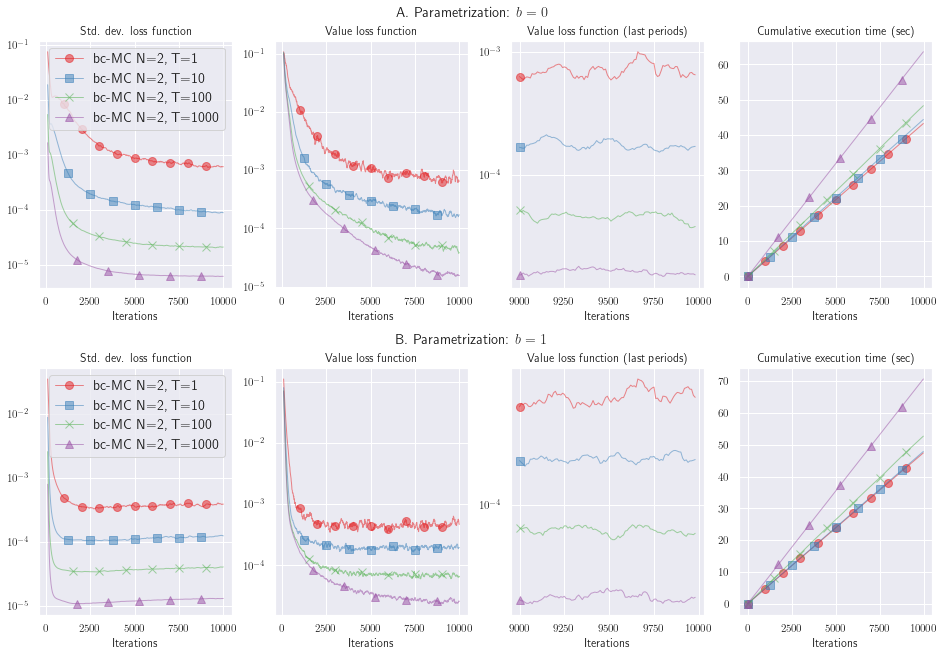

     bc optim     lr  N     M     T  N_star
8   0.0  Adam  0.001  2     1     1   False
9   0.0  Adam  0.001  2    10    10   False
10  0.0  Adam  0.001  2   100   100   False
11  0.0  Adam  0.001  2  1000  1000   False
     bc optim     lr  N     M     T  N_star
8   1.0  Adam  0.001  2     1     1   False
9   1.0  Adam  0.001  2    10    10   False
10  1.0  Adam  0.001  2   100   100   False
11  1.0  Adam  0.001  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


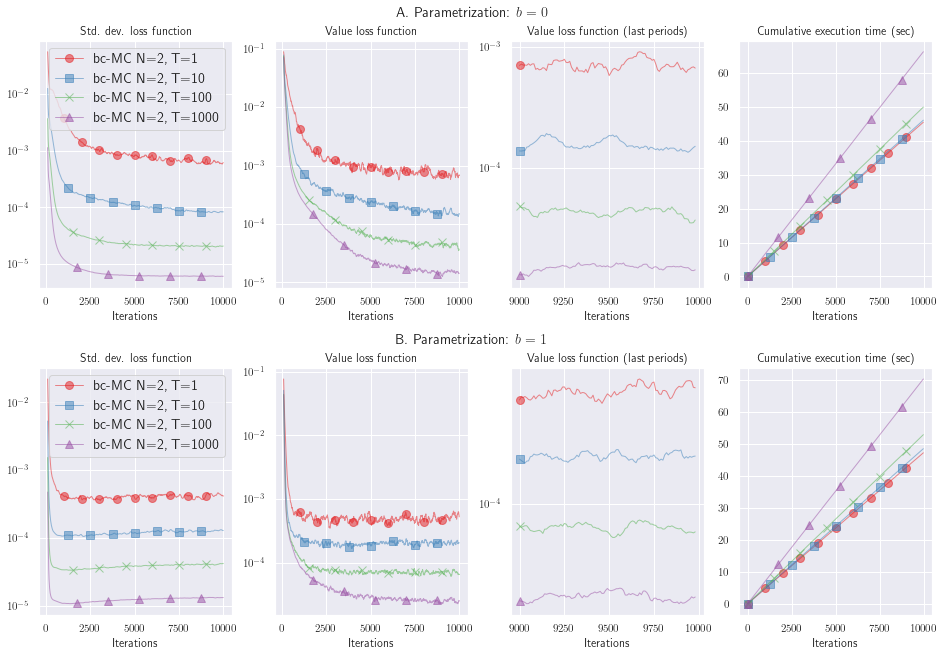

    bc optim    lr  N     M     T  N_star
4  0.0  Adam  0.01  2     1     1   False
5  0.0  Adam  0.01  2    10    10   False
6  0.0  Adam  0.01  2   100   100   False
7  0.0  Adam  0.01  2  1000  1000   False
    bc optim    lr  N     M     T  N_star
4  1.0  Adam  0.01  2     1     1   False
5  1.0  Adam  0.01  2    10    10   False
6  1.0  Adam  0.01  2   100   100   False
7  1.0  Adam  0.01  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


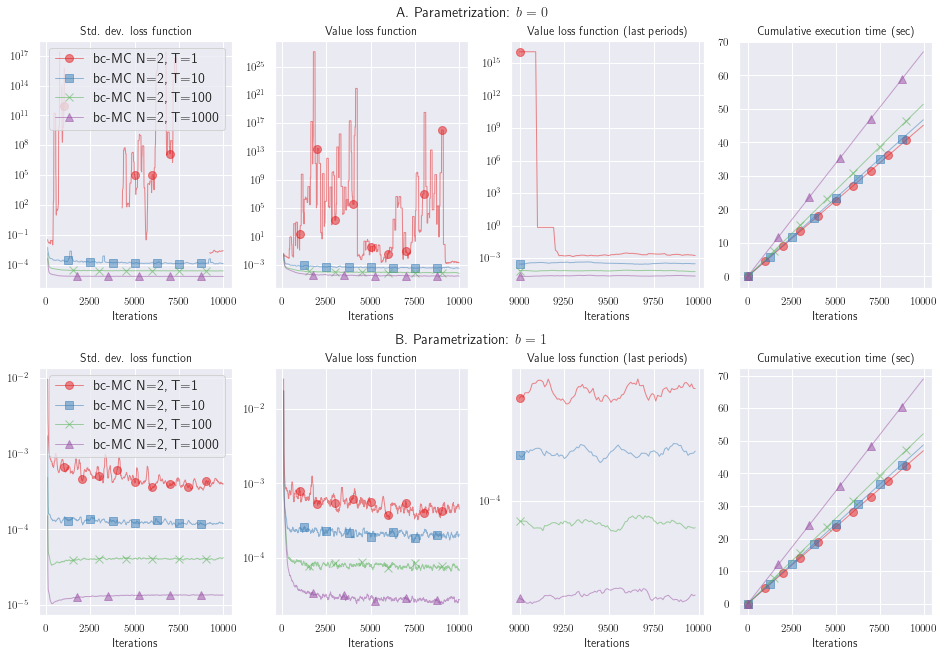

    bc optim    lr  N     M     T  N_star
0  0.0  Adam  0.05  2     1     1   False
1  0.0  Adam  0.05  2    10    10   False
2  0.0  Adam  0.05  2   100   100   False
3  0.0  Adam  0.05  2  1000  1000   False
    bc optim    lr  N     M     T  N_star
0  1.0  Adam  0.05  2     1     1   False
1  1.0  Adam  0.05  2    10    10   False
2  1.0  Adam  0.05  2   100   100   False
3  1.0  Adam  0.05  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


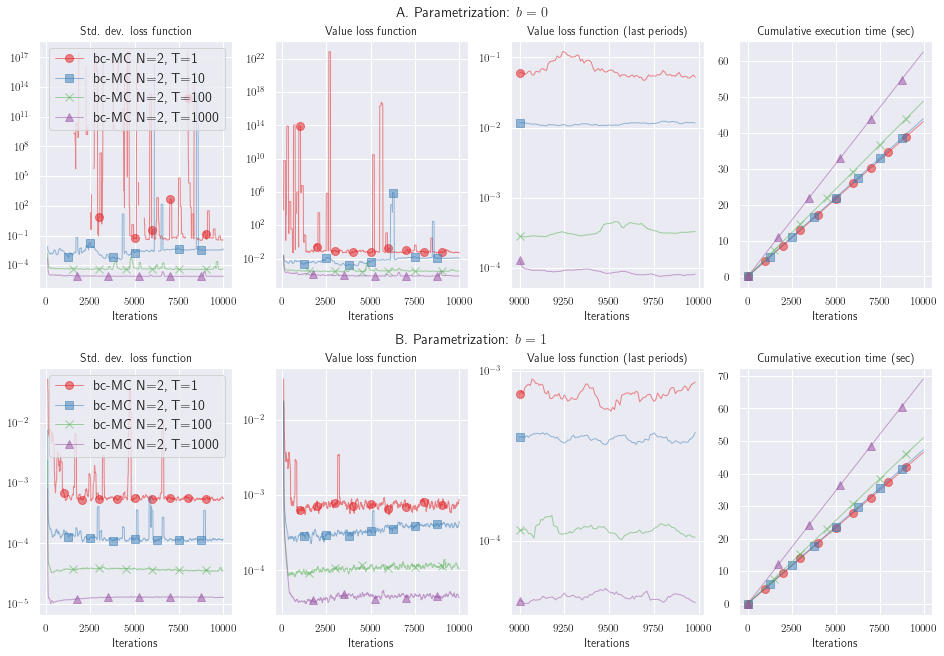

No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

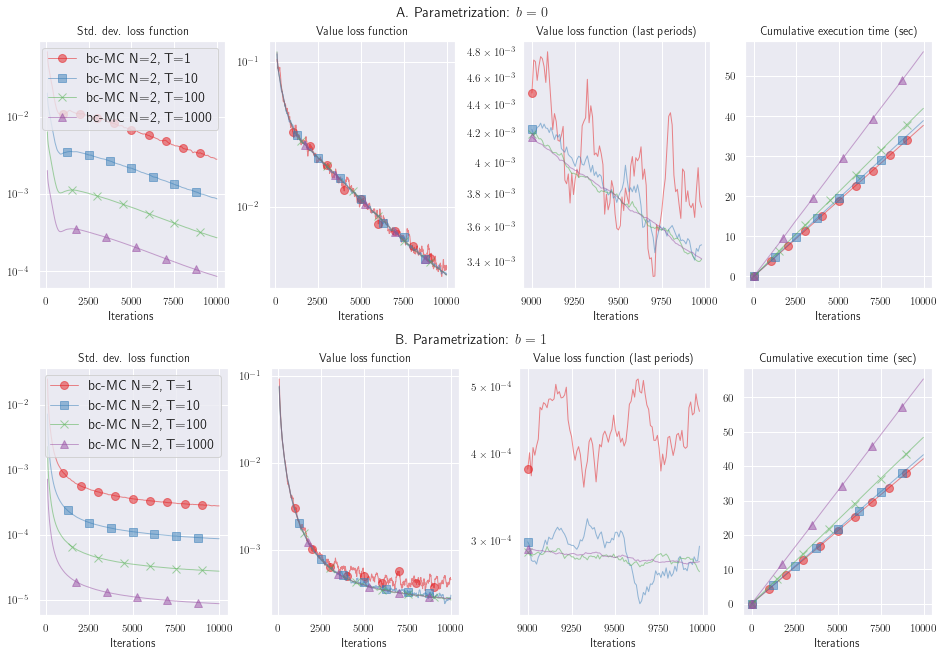

No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
     bc optim   lr  N     M     T  N_star
8   0.0   SGD  0.1  2     1     1   False
9   0.0   SGD  0.1  2    10    10   False
10  0.0   SGD  0.1  2   100   100   False
11  0.0   SGD  0.1  2  1000  1000   False
     bc optim   lr  N     M     T  N_star
8   1.0   SGD  0.1  2     1     1   False
9   1.0   SGD  0.1  2    10    10   False
10  1.0   SGD  0.1  2   100   100   False
11  1.0   SGD  0.1  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


<Figure size 936x648 with 0 Axes>

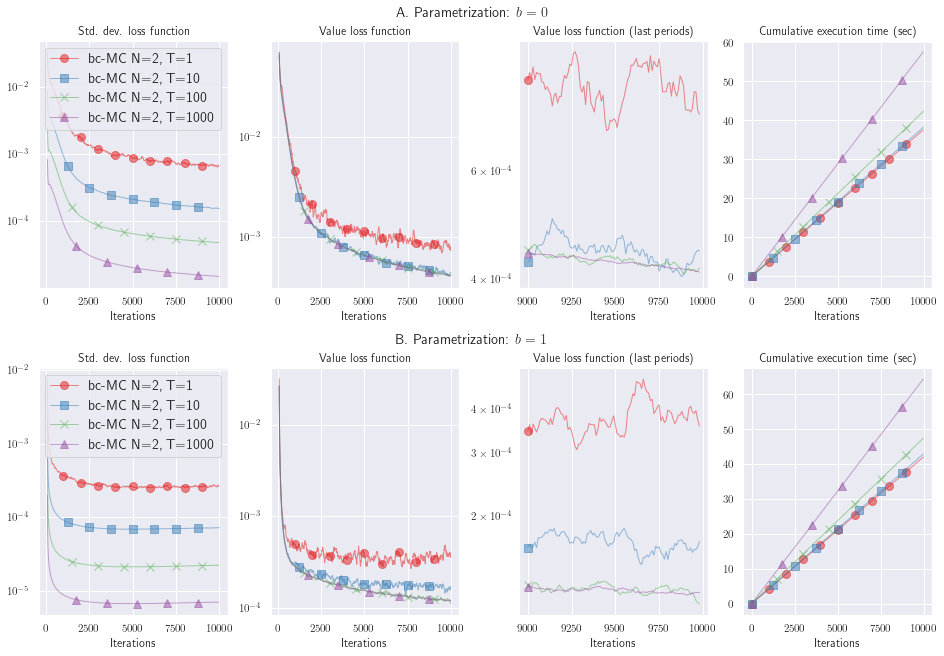

    bc optim   lr  N     M     T  N_star
4  0.0   SGD  1.0  2     1     1   False
5  0.0   SGD  1.0  2    10    10   False
6  0.0   SGD  1.0  2   100   100   False
7  0.0   SGD  1.0  2  1000  1000   False
    bc optim   lr  N     M     T  N_star
4  1.0   SGD  1.0  2     1     1   False
5  1.0   SGD  1.0  2    10    10   False
6  1.0   SGD  1.0  2   100   100   False
7  1.0   SGD  1.0  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


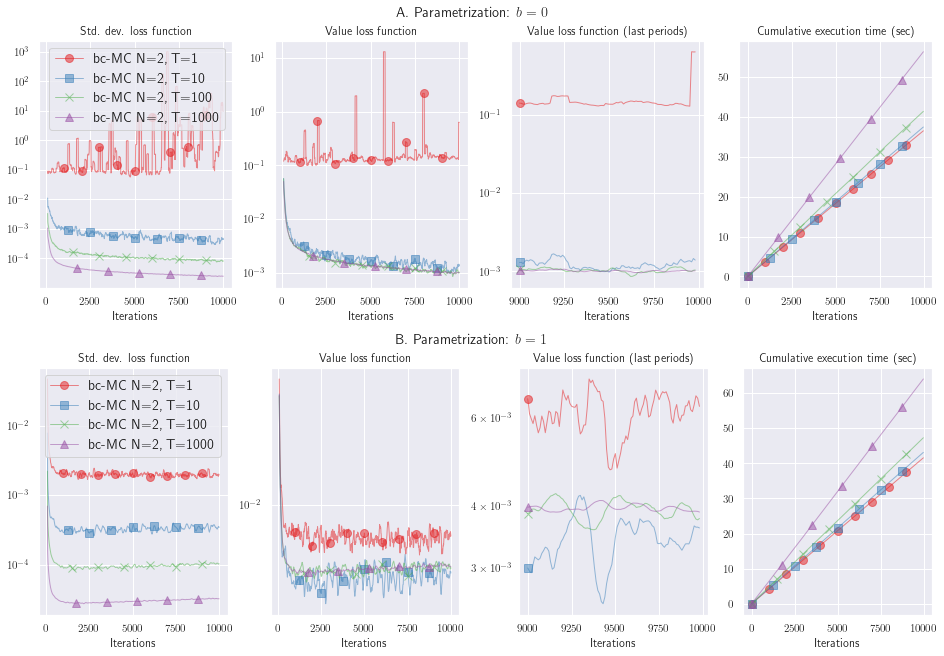

    bc optim   lr  N     M     T  N_star
0  0.0   SGD  2.0  2     1     1   False
1  0.0   SGD  2.0  2    10    10   False
2  0.0   SGD  2.0  2   100   100   False
3  0.0   SGD  2.0  2  1000  1000   False
    bc optim   lr  N     M     T  N_star
0  1.0   SGD  2.0  2     1     1   False
1  1.0   SGD  2.0  2    10    10   False
2  1.0   SGD  2.0  2   100   100   False
3  1.0   SGD  2.0  2  1000  1000   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


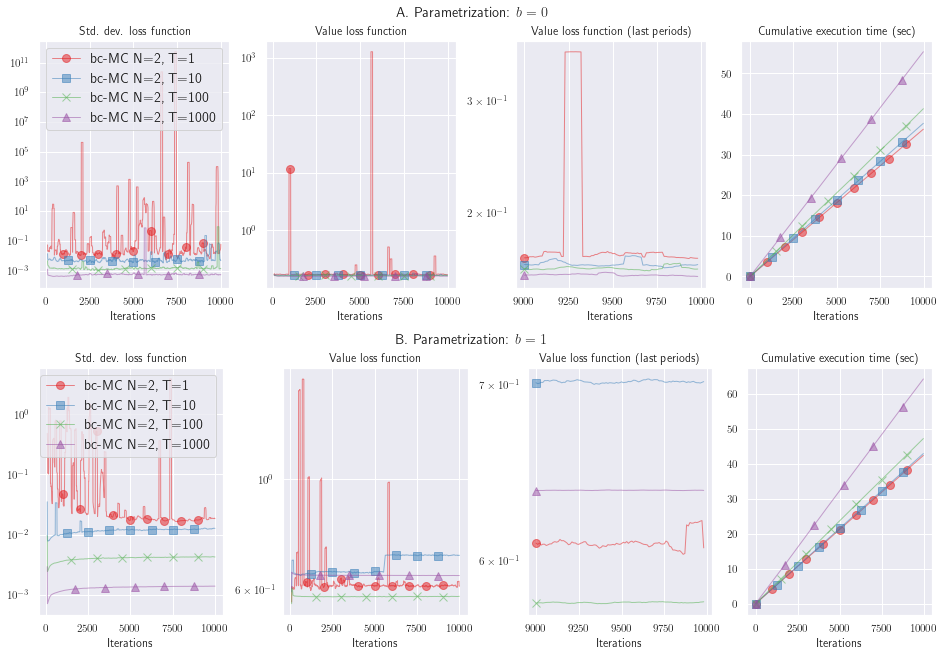

In [10]:
# One page plot, with zonn             
mult = 2
#Read all hyperparameters
extension_csv_file = "changing_M"
create_zoom = True #add a zoom on the last periods of losses
list_lr = []
list_optim = []

for nb in range(min_nb_plot, max_nb_plot):
    output_extension = f"bc_{nb}"
    local_path = os.getcwd() + f'/{output_extension}/file/content/output/'
    path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
    if os.path.isfile(path_hyperparams) == True:
        df_hyperparams = pd.read_csv(path_hyperparams)
        list_lr.append(list(np.unique(df_hyperparams['lr'])))
        list_optim.append(list(np.unique(df_hyperparams['optim'])))
# make unique
list_lr = np.unique(list_lr)
list_optim = np.unique(list_optim)

# Define your subtitles
row_titles = [r'A. Parametrization: $b = 0$', 
              r'B. Parametrization: $b = 1$']

for optim_selected in list_optim:
    for lr_selected in list_lr: 
        plot_nb = -1 #initialization
        fig = plt.figure(constrained_layout=True, figsize=(mult*6.5, 0.5*mult*9))
        (subfig0, subfig1) = fig.subfigures(2, 1) # create 4x1 subfigures
        
        graph_empty=True
        for nb in range(min_nb_plot, max_nb_plot):
            output_extension = f"bc_{nb}"
            output_folder = current_wd  + f"/output/{output_extension}/"

            # Create folder if does not exist:
            if not os.path.exists(output_folder):
                # If it doesn't exist, create it
                os.makedirs(output_folder)
                
            # Load files
            #extension_csv_file = "changing_M"
            local_path = os.getcwd() + f'/{output_extension}/file/content/output/'

            # LOAD DATA
            if read_from_csv == True:
                #print("Reading CSV")
                path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
                if os.path.isfile(path_hyperparams) == True:
                    df_hyperparams = pd.read_csv(path_hyperparams)
                else:
                    print(f"No file {'hyperparams_{extension_csv_file}.csv'} found for nb {nb}")
                    continue

                list_dfs_hyperparams = []
                for index, row in df_hyperparams.iterrows():
                    bc_chosen = row['bc']
                    optimizer_chosen = row["optim"]
                    lr_chosen = row["lr"]
                    N_chosen = row["N"]
                    M_chosen = row["M"]
                    use_N_star = row["N_star"]
                    # Load
                    filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
                    list_dfs_hyperparams.append(pd.read_csv(filen))


            list_combinations_used = []
            for index, row in df_hyperparams.iterrows():
                bc_chosen = row['bc']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]

                combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
                if combination not in list_combinations_used:
                    list_combinations_used.append(combination)
                else:
                    continue #If combination already used, pass

                # Pass if lr
                if (lr_chosen != lr_selected) | (optimizer_chosen != optim_selected):
                    continue
                else: 
                    graph_empty = False
                    plot_nb+=1
                    if plot_nb>3:
                        break

                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["bc"] == bc_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)


                list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                if create_zoom == False:
                    (ax2, ax3, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 3)")
                else:
                    (ax2, ax3, ax4, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 4)")
                    
                eval(f"subfig{plot_nb}.suptitle(row_titles[{plot_nb}])")

                #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
                for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                    #fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                    """
                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")
                    """

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")

                    if create_zoom == True:
                        min_index_local = np.argmin(np.abs(df["iter"] - 9000)) #1500 
                        max_index_local = np.argmin(np.abs(df["iter"] - 10000)) #2000
                        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                            ax4.plot(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                            if display_CI==True:
                                ax4.fill_between(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local] - mult*MA_std[min_index_local:max_index_local], MA_series[min_index_local:max_index_local] + mult*MA_std[min_index_local:max_index_local], color=c, alpha=alpha_bands)
                        ax4.set_yscale('log')
                        #ax3.set_xscale('log')
                        ax4.set_title('Value loss function (last periods)')
                        ax4.set_xlabel("Iterations")
                    
                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

        if graph_empty == False:
            figname = os.getcwd() + f'/output/model_bc_{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.png'
            plt.savefig(figname, bbox_inches="tight", dpi=300)

            figname = os.getcwd() + f'/output/model_bc_{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.pdf'
            plt.savefig(figname, bbox_inches="tight", dpi=600)
            plt.show()

### B. Vary M and N and test optimal N*

In [11]:
extension_csv_file = "opt_N"
create_small_plots = False

if create_small_plots == True:
    for nb in range(min_nb_plot, max_nb_plot):
        output_extension = f"bc_{nb}"
        output_folder = current_wd  + f"/output/{output_extension}/"

        # Create folder if does not exist:
        if not os.path.exists(output_folder):
            # If it doesn't exist, create it
            os.makedirs(output_folder)

        # Load files
        local_path = os.getcwd() + f'/{output_extension}/file/content/output/'
        #print(local_path)
        
        # LOAD DATA
        if read_from_csv == True:
            print("Reading CSV")

            path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
            if os.path.isfile(path_hyperparams) == True:
                df_hyperparams = pd.read_csv(path_hyperparams)
            else:
                print(f"No file hyperparams_{extension_csv_file}.csv found for nb {nb}")
                continue
            #print(df_hyperparams)

            list_dfs_hyperparams = []
            for index, row in df_hyperparams.iterrows():
                bc_chosen = row['bc']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]
                # Load
                filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
                list_dfs_hyperparams.append(pd.read_csv(filen))


        list_combinations_used = []
        for index, row in df_hyperparams.iterrows():
            bc_chosen = row['bc']
            optimizer_chosen = row["optim"]
            lr_chosen = row["lr"]
            N_chosen = row["N"]
            M_chosen = row["M"]
            use_N_star = row["N_star"]

            combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
            if combination not in list_combinations_used:
                list_combinations_used.append(combination)
            else:
                continue #If combination already used, pass
            df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
            df_sel = df_sel[df_sel["bc"] == bc_chosen]
            df_sel = df_sel[df_sel["lr"] == lr_chosen]
            print(df_sel)


            list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
            list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
            list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
            list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
            list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

            list_labels = []
            for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                if N_star == True:
                    list_labels += [f"bc-MC N*, T={T}"]
                else:
                    list_labels += [f"bc-MC N={N}, T={T}"]
            #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

            #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
            for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                var = "var_loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax2.set_yscale('log')
                ax2.set_title('Std. dev. loss function')
                ax2.legend(loc="upper right")
                ax2.set_xlabel("Iterations")

                var = "loss"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                    MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                    ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                ax3.set_yscale('log')
                ax3.set_title('Value loss function')
                ax3.set_xlabel("Iterations")

                var = "time"
                for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                    ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    if display_CI==True:
                        ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                ax5.set_xlabel("Iterations")
                ax5.set_title("Cumulative execution time (sec)")

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.png'
                plt.savefig(figname, bbox_inches="tight", dpi=300)

                figname = output_folder + f'{output_extension}-{extension_csv_file}_loop_{index}_{i}.pdf'
                plt.savefig(figname, bbox_inches="tight", dpi=300)
                plt.show()



### Create a one-page plots

     bc optim      lr    N    M    T  N_star
12  0.0  Adam  0.0005    2  100  100    True
13  0.0  Adam  0.0005  100    2  100   False
14  0.0  Adam  0.0005   20   10  100   False
15  0.0  Adam  0.0005    2  100  100   False
     bc optim      lr    N    M    T  N_star
12  1.0  Adam  0.0005    2  100  100    True
13  1.0  Adam  0.0005  100    2  100   False
14  1.0  Adam  0.0005   20   10  100   False
15  1.0  Adam  0.0005    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


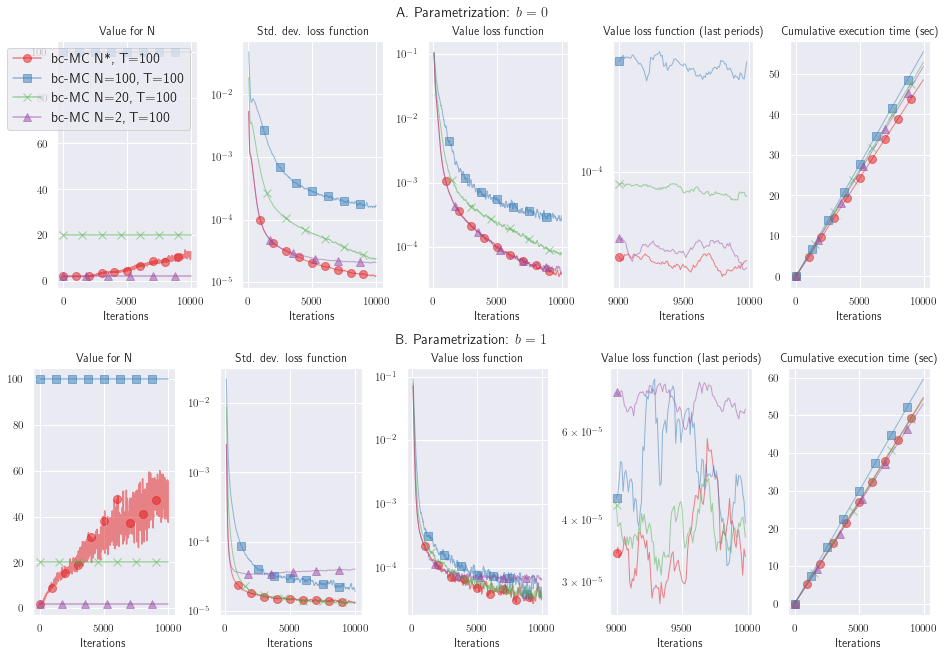

     bc optim     lr    N    M    T  N_star
8   0.0  Adam  0.001    2  100  100    True
9   0.0  Adam  0.001  100    2  100   False
10  0.0  Adam  0.001   20   10  100   False
11  0.0  Adam  0.001    2  100  100   False
     bc optim     lr    N    M    T  N_star
8   1.0  Adam  0.001    2  100  100    True
9   1.0  Adam  0.001  100    2  100   False
10  1.0  Adam  0.001   20   10  100   False
11  1.0  Adam  0.001    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


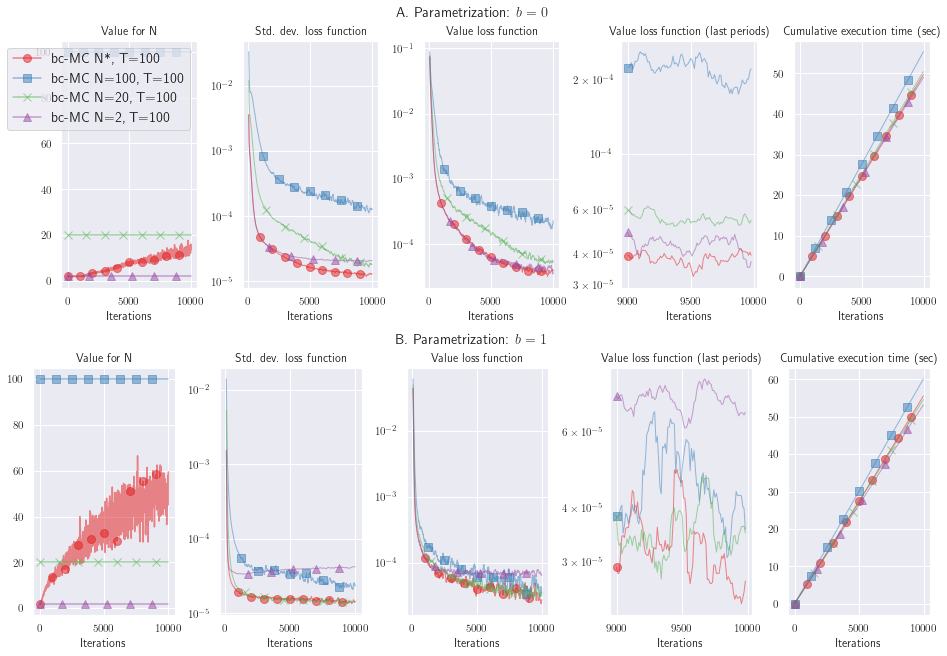

    bc optim    lr    N    M    T  N_star
4  0.0  Adam  0.01    2  100  100    True
5  0.0  Adam  0.01  100    2  100   False
6  0.0  Adam  0.01   20   10  100   False
7  0.0  Adam  0.01    2  100  100   False
    bc optim    lr    N    M    T  N_star
4  1.0  Adam  0.01    2  100  100    True
5  1.0  Adam  0.01  100    2  100   False
6  1.0  Adam  0.01   20   10  100   False
7  1.0  Adam  0.01    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


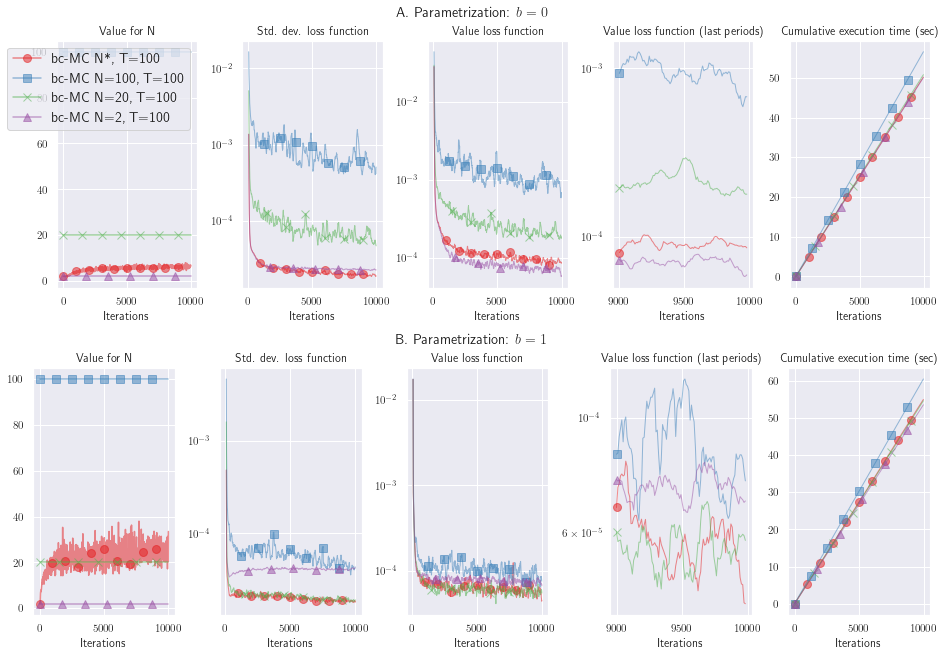

    bc optim    lr    N    M    T  N_star
0  0.0  Adam  0.05    2  100  100    True
1  0.0  Adam  0.05  100    2  100   False
2  0.0  Adam  0.05   20   10  100   False
3  0.0  Adam  0.05    2  100  100   False
    bc optim    lr    N    M    T  N_star
0  1.0  Adam  0.05    2  100  100    True
1  1.0  Adam  0.05  100    2  100   False
2  1.0  Adam  0.05   20   10  100   False
3  1.0  Adam  0.05    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


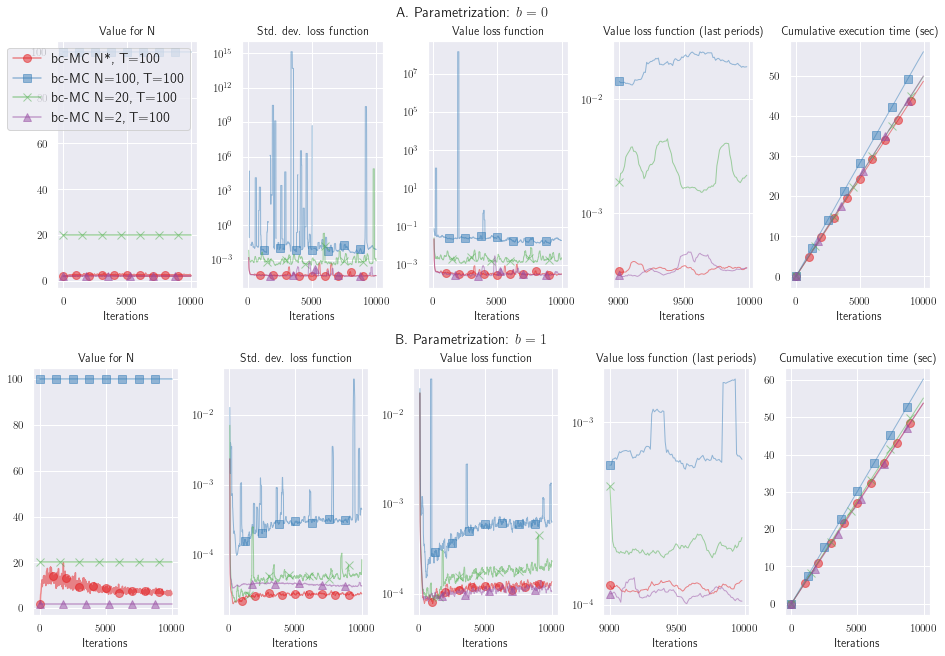

No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
No file hyperparams_{extension_csv_file}

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

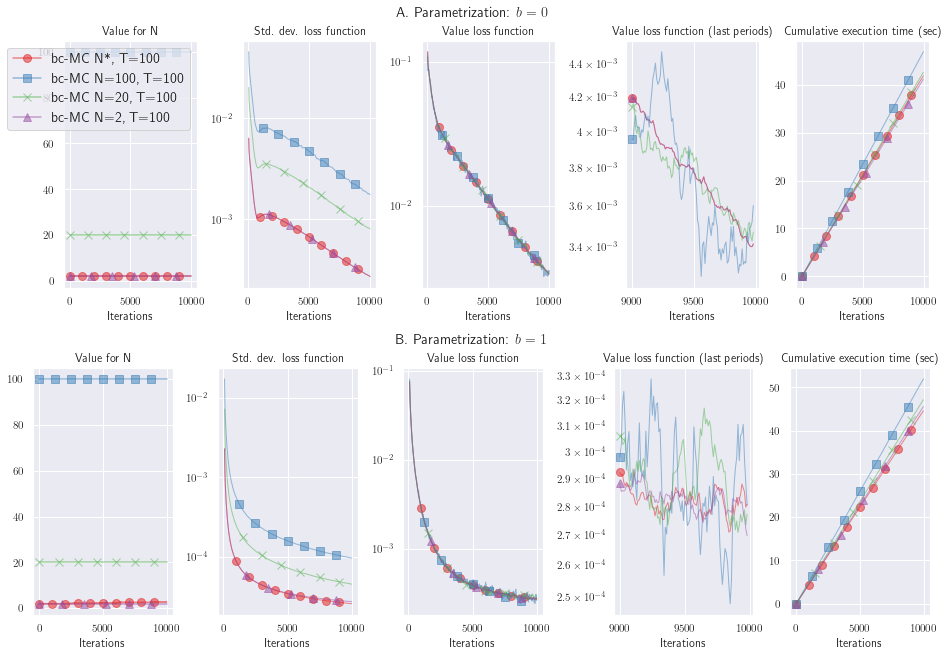

No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8
     bc optim   lr    N    M    T  N_star
8   0.0   SGD  0.1    2  100  100    True
9   0.0   SGD  0.1  100    2  100   False
10  0.0   SGD  0.1   20   10  100   False
11  0.0   SGD  0.1    2  100  100   False
     bc optim   lr    N    M    T  N_star
8   1.0   SGD  0.1    2  100  100    True
9   1.0   SGD  0.1  100    2  100   False
10  1.0   SGD  0.1   20   10  100   False
11  1.0   SGD  0.1    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


<Figure size 936x648 with 0 Axes>

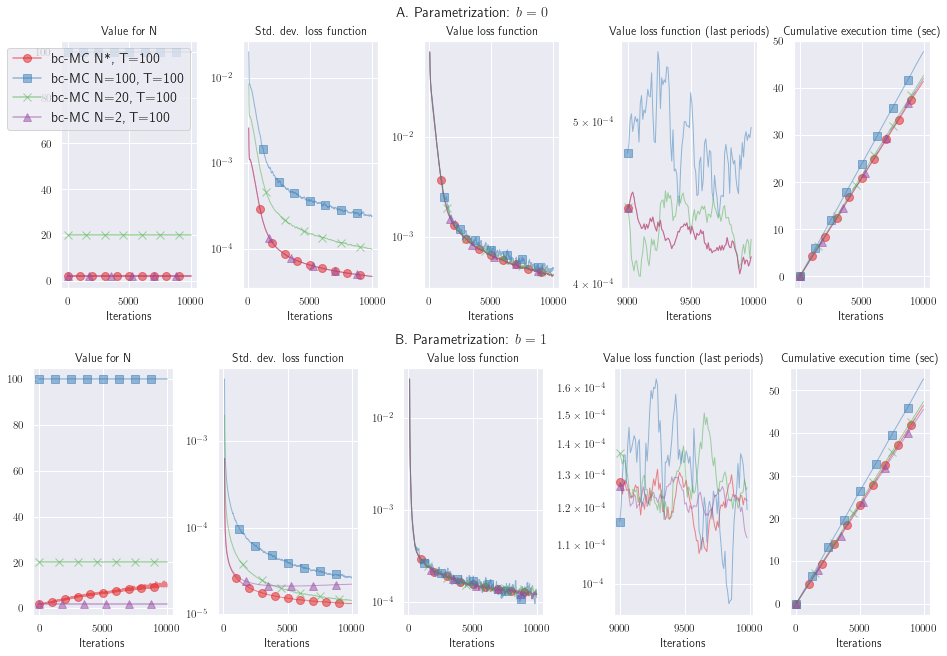

    bc optim   lr    N    M    T  N_star
4  0.0   SGD  1.0    2  100  100    True
5  0.0   SGD  1.0  100    2  100   False
6  0.0   SGD  1.0   20   10  100   False
7  0.0   SGD  1.0    2  100  100   False
    bc optim   lr    N    M    T  N_star
4  1.0   SGD  1.0    2  100  100    True
5  1.0   SGD  1.0  100    2  100   False
6  1.0   SGD  1.0   20   10  100   False
7  1.0   SGD  1.0    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


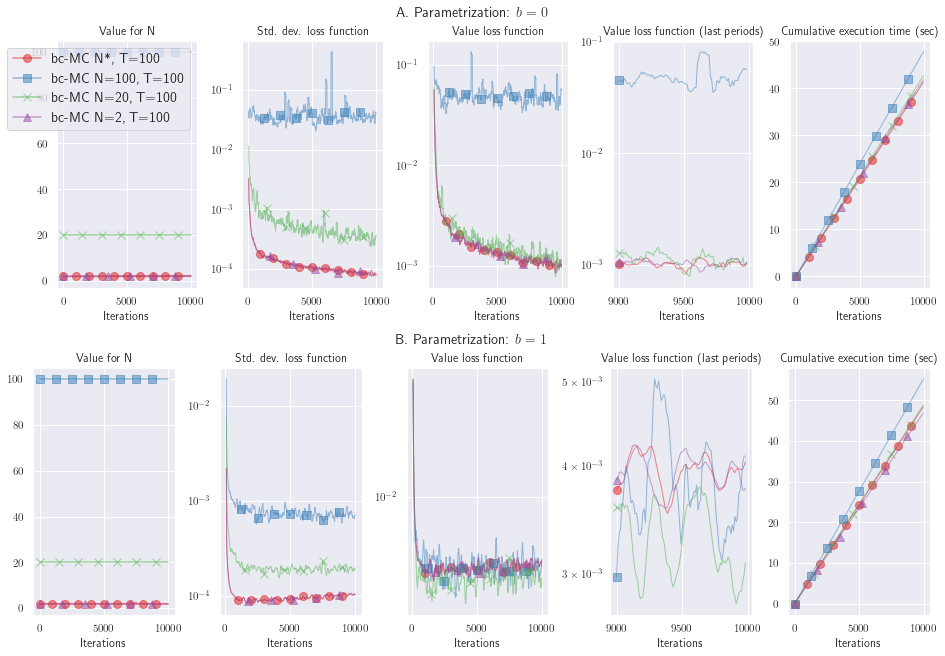

    bc optim   lr    N    M    T  N_star
0  0.0   SGD  2.0    2  100  100    True
1  0.0   SGD  2.0  100    2  100   False
2  0.0   SGD  2.0   20   10  100   False
3  0.0   SGD  2.0    2  100  100   False
    bc optim   lr    N    M    T  N_star
0  1.0   SGD  2.0    2  100  100    True
1  1.0   SGD  2.0  100    2  100   False
2  1.0   SGD  2.0   20   10  100   False
3  1.0   SGD  2.0    2  100  100   False
No file hyperparams_{extension_csv_file}.csv found for nb 5
No file hyperparams_{extension_csv_file}.csv found for nb 6
No file hyperparams_{extension_csv_file}.csv found for nb 7
No file hyperparams_{extension_csv_file}.csv found for nb 8


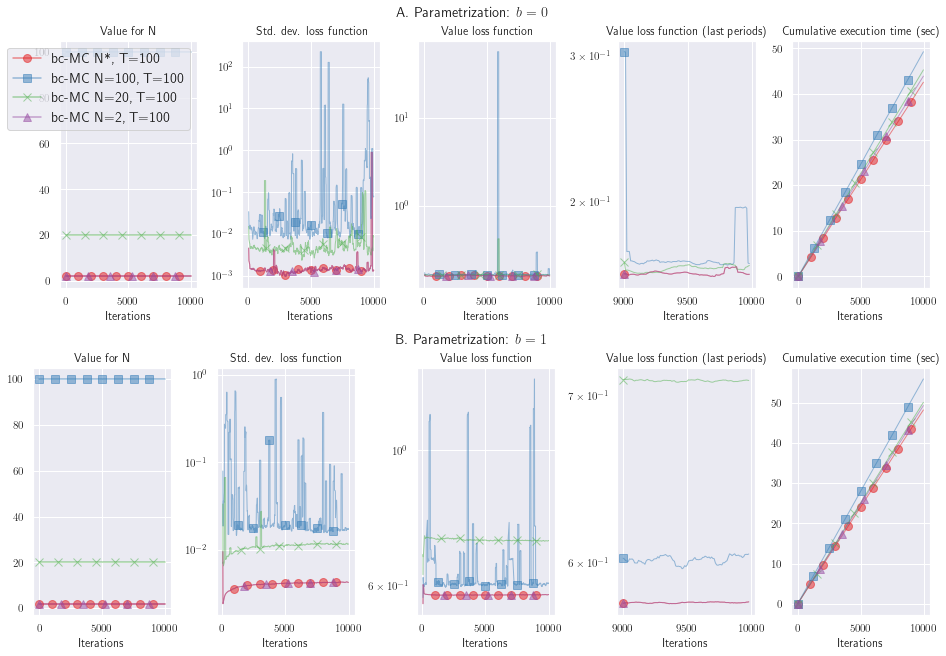

In [12]:
mult = 2
#Read all hyperparameters
extension_csv_file = "opt_N"
create_zoom = True #add a zoom on the last periods of losses
list_lr = []
list_optim = []

for nb in range(min_nb_plot, max_nb_plot):
    output_extension = f"bc_{nb}"
    local_path = os.getcwd() + f'/{output_extension}/file/content/output/'
    path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
    if os.path.isfile(path_hyperparams) == True:
        df_hyperparams = pd.read_csv(path_hyperparams)
        list_lr.append(list(np.unique(df_hyperparams['lr'])))
        list_optim.append(list(np.unique(df_hyperparams['optim'])))
# make unique
list_lr = np.unique(list_lr)
list_optim = np.unique(list_optim)

# Define your subtitles
row_titles = [r'A. Parametrization: $b = 0$', 
              r'B. Parametrization: $b = 1$']

for optim_selected in list_optim:
    for lr_selected in list_lr: 
        plot_nb = -1 #initialization
        fig = plt.figure(constrained_layout=True, figsize=(mult*6.5, 0.5*mult*9))
        (subfig0, subfig1) = fig.subfigures(2, 1) # create 4x1 subfigures
        
        graph_empty=True
        for nb in range(min_nb_plot, max_nb_plot):
            output_extension = f"bc_{nb}"
            output_folder = current_wd  + f"/output/{output_extension}/"

            # Create folder if does not exist:
            if not os.path.exists(output_folder):
                # If it doesn't exist, create it
                os.makedirs(output_folder)
            
            # Load files
            #extension_csv_file = "changing_M"
            local_path = os.getcwd() + f'/{output_extension}/file/content/output/'

            # LOAD DATA
            if read_from_csv == True:
                #print("Reading CSV")
                path_hyperparams = local_path  + f'hyperparams_{extension_csv_file}.csv'
                if os.path.isfile(path_hyperparams) == True:
                    df_hyperparams = pd.read_csv(path_hyperparams)
                else:
                    print(f"No file {'hyperparams_{extension_csv_file}.csv'} found for nb {nb}")
                    continue

                list_dfs_hyperparams = []
                for index, row in df_hyperparams.iterrows():
                    bc_chosen = row['bc']
                    optimizer_chosen = row["optim"]
                    lr_chosen = row["lr"]
                    N_chosen = row["N"]
                    M_chosen = row["M"]
                    use_N_star = row["N_star"]
                    # Load
                    filen = local_path + f'df_bcMC_{extension_csv_file}_{N_chosen}_M_{M_chosen}_Nstar_{use_N_star}_lr_{lr_chosen}_optim_{optimizer_chosen}_bc_{bc_chosen}.csv'
                    list_dfs_hyperparams.append(pd.read_csv(filen))


            list_combinations_used = []
            for index, row in df_hyperparams.iterrows():
                bc_chosen = row['bc']
                optimizer_chosen = row["optim"]
                lr_chosen = row["lr"]
                N_chosen = row["N"]
                M_chosen = row["M"]
                use_N_star = row["N_star"]

                combination = f'{optimizer_chosen}-{bc_chosen}-{lr_chosen}'
                if combination not in list_combinations_used:
                    list_combinations_used.append(combination)
                else:
                    continue #If combination already used, pass

                # Pass if lr
                if (lr_chosen != lr_selected) | (optimizer_chosen != optim_selected):
                    continue
                else: 
                    graph_empty = False
                    plot_nb+=1
                    if plot_nb>3:
                        break

                df_sel = df_hyperparams[df_hyperparams["optim"] == optimizer_chosen]
                df_sel = df_sel[df_sel["bc"] == bc_chosen]
                df_sel = df_sel[df_sel["lr"] == lr_chosen]
                print(df_sel)


                list_dfs = [list_dfs_hyperparams[k] for k in df_sel.index]
                list_dfs_N = [df_sel.loc[k, "N"] for k in df_sel.index]
                list_dfs_M = [df_sel.loc[k, "M"] for k in df_sel.index]
                list_dfs_T = [df_sel.loc[k, "T"] for k in df_sel.index]
                list_dfs_N_star = [df_sel.loc[k, "N_star"] for k in df_sel.index]

                list_labels = []
                for (N, N_star, T) in zip(list_dfs_N, list_dfs_N_star, list_dfs_T):
                    if N_star == True:
                        list_labels += [f"bc-MC N*, T={T}"]
                    else:
                        list_labels += [f"bc-MC N={N}, T={T}"]
                #list_labels = ["bc-MC N*, T=100", "bc-MC N=2, T=100",  "bc-MC N=100, T=100", "bc-MC N=20, T=100", "bc-MC N=2, T=1000"]

                if create_zoom == False:
                    (ax1, ax2, ax3, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 4)")
                else:
                    (ax1, ax2, ax3, ax4, ax5) =  eval(f"subfig{plot_nb}.subplots(1, 5)")
                    
                eval(f"subfig{plot_nb}.suptitle(row_titles[{plot_nb}])")

                #for (i, (min_index, max_index)) in enumerate(zip([0, 3000], [1000, nb_epochs_chosen])):
                for (i, (min_index, max_index)) in enumerate(zip([0], [3000])):
                    #fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
                    #fig, (ax2, ax3, ax4, ax5) = plt.subplots(1, 4)
                    #fig, (ax2, ax3, ax5) = plt.subplots(1, 3)

                    
                    var = "optimal_N"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax1.plot(df["iter"][min_index:max_index], df[f"{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen)
                    #ax1.set_yscale('log')
                    ax1.set_title('Value for N')
                    ax1.set_xlabel("Iterations")
                    if plot_nb == 0:
                        ax1.legend(loc="upper right")

                    var = "var_loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(np.sqrt(np.maximum(df[f"{prefix}{var}"], tol_float))).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(np.sqrt(np.maximum(df[f"std_{var}"], tol_float))).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax2.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax2.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax2.set_yscale('log')
                    ax2.set_title('Std. dev. loss function')
                    #ax2.legend(loc="upper right")
                    ax2.set_xlabel("Iterations")

                    var = "loss"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                        MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                        ax3.plot(df["iter"][min_index:max_index], MA_series[min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax3.fill_between(df["iter"][min_index:max_index], MA_series[min_index:max_index] - mult*MA_std[min_index:max_index], MA_series[min_index:max_index] + mult*MA_std[min_index:max_index], color=c, alpha=alpha_bands)
                    ax3.set_yscale('log')
                    ax3.set_title('Value loss function')
                    ax3.set_xlabel("Iterations")

                    if create_zoom == True:
                        min_index_local = np.argmin(np.abs(df["iter"] - 9000)) #1500 
                        max_index_local = np.argmin(np.abs(df["iter"] - 10000)) #2000
                        for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                            MA_series = pd.Series(df[f"{prefix}{var}"]).rolling(rate).mean() # Moving average series
                            MA_std = pd.Series(df[f"std_{var}"]).rolling(rate).mean() # Moving average std dev. across series, for same hyperparams
                            ax4.plot(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                            if display_CI==True:
                                ax4.fill_between(df["iter"][min_index_local:max_index_local], MA_series[min_index_local:max_index_local] - mult*MA_std[min_index_local:max_index_local], MA_series[min_index_local:max_index_local] + mult*MA_std[min_index_local:max_index_local], color=c, alpha=alpha_bands)
                        ax4.set_yscale('log')
                        #ax3.set_xscale('log')
                        ax4.set_title('Value loss function (last periods)')
                        ax4.set_xlabel("Iterations")
                    
                    var = "time"
                    for (df, l, m, c, f) in zip(list_dfs, list_labels, markers, colors, list_freq_markers):
                        ax5.plot(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index], label=l, color=c, marker=m, markevery=f, markersize=markersize, alpha=alpha_chosen, linewidth=linewidth_chosen)
                        if display_CI==True:
                            ax5.fill_between(df["iter"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] - mult*df[f"std_{var}"][min_index:max_index], df[f"{prefix}{var}"][min_index:max_index] + mult*df[f"std_{var}"][min_index:max_index], color=c, alpha=alpha_bands)

                    ax5.set_xlabel("Iterations")
                    ax5.set_title("Cumulative execution time (sec)")

        if graph_empty == False:
            figname = os.getcwd() + f'/output/model_bc_{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.png'
            plt.savefig(figname, bbox_inches="tight", dpi=300)

            figname = os.getcwd() + f'/output/model_bc_{extension_csv_file}_lr_{lr_selected}_optim_{optim_selected}_one_page_zoom_{create_zoom}.pdf'
            plt.savefig(figname, bbox_inches="tight", dpi=600)
            plt.show()